In [19]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, RecurrentNetwork, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, TorchNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, RMSE

from importlib import reload



In [20]:
data = generate_ar_data(seasonality=20.0, timesteps=5000, n_series=1, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")


In [21]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

validation_cutoff = data["time_idx"].max() - 1000
training_cutoff = validation_cutoff - max_prediction_length


context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,series,time_idx,value,date
0,0,0,0.000000,2020-01-01
1,0,1,0.024652,2020-01-02
2,0,2,0.058442,2020-01-03
3,0,3,0.081475,2020-01-04
4,0,4,0.096084,2020-01-05


Optimal parameters:  alpha_mu = 0.9999338930386481,  alpha_sigma = 0.9999338930386481, mu_0 = 0.1577118174565007, sigma2_0 = 0.46867347930973713, beta_mu = 0.9983830029070916, beta_sigma = 0.12284220613202086, omega_mu = 0.0014792123075187114, omega_sigma = 0.41307339858826836, nu = 99.99996367243563
alpha_mu:  0.9999338930386481 alpha_sigma:  0.9999338930386481 beta_mu:  0.9983830029070916 beta_sigma:  0.12284220613202086 omega_mu:  0.0014792123075187114 omega_sigma:  0.41307339858826836 nu:  99.99996367243563


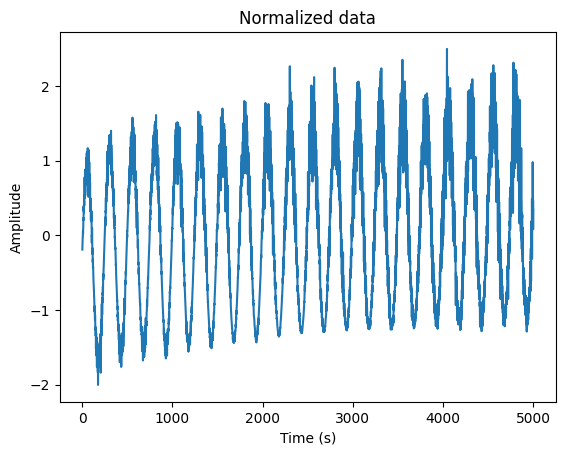

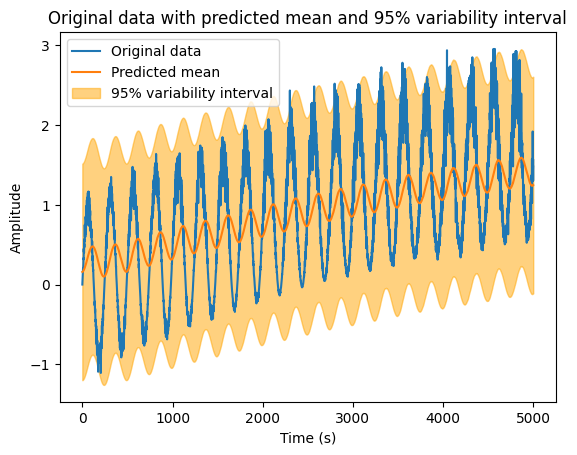

In [22]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 0.01
var_norm_strength = 0.01

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]


mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(data['value'], data['value'][:validation_cutoff],  mode='predict', norm_strength=norm_strength)

gas_params = alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength

#print all gas parameters in one line
print('alpha_mu: ', alpha_mu, 'alpha_sigma: ', alpha_sigma, 'beta_mu: ', beta_mu, 'beta_sigma: ', beta_sigma, 'omega_mu: ', omega_mu, 'omega_sigma: ', omega_sigma, 'nu: ', nu)


#Plot the normalized data

plt.plot(data['time_idx'][1:], y_norm[1:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

plt.plot(data['time_idx'], data['value'], label='Original data')
plt.plot(data['time_idx'], mu_list, label='Predicted mean')
plt.fill_between(data['time_idx'], mu_list-1.96*np.sqrt(sigma2_list), mu_list+1.96*np.sqrt(sigma2_list), alpha=0.5, label='95% variability interval', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original data with predicted mean and 95% variability interval')
plt.legend()

In [23]:
#Add mean and variance to the dataframe

data['mu'] = mu_list
data['sigma2'] = sigma2_list

data.head()

,series,time_idx,value,date,mu,sigma2
0,0,0,0.000000,2020-01-01,0.158145,0.479972
1,0,1,0.024652,2020-01-02,0.158699,0.480179
2,0,2,0.058442,2020-01-03,0.159419,0.480200
3,0,3,0.081475,2020-01-04,0.160250,0.480200
4,0,4,0.096084,2020-01-05,0.161148,0.480198


In [52]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=['mu', 'sigma2'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer= TorchNormalizer(method="identity", center=False),
    scalers={'mu': None, 'sigma2': None}
)

validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx <= validation_cutoff], min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=validation_cutoff + 1)

batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, shuffle=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, shuffle=False
)

test_dataloader = test.to_dataloader(
    train=False, batch_size=1, num_workers=0, shuffle=False
)

In [25]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3774)

In [26]:
from importlib import reload
import GAS_LSTM
reload(GAS_LSTM)
from GAS_LSTM import GAS_LSTM, GAS_MAE

pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = GAS_LSTM.from_dataset(
    training,
    cell_type="LSTM",   
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=GAS_MAE(),
    optimizer="Adam",
    gas_params= gas_params,
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.9496]]), tensor([[0.0323]]), tensor([[0.0312]]), tensor([[0.0295]]), tensor([[0.0278]]), tensor([[0.0265]]), tensor([[0.0255]]), tensor([[0.0248]]), tensor([[0.0244]]), tensor([[0.0241]]), tensor([[0.0239]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0237]]), tensor([[0.0237]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]])

Finding best initial lr:  29%|██▉       | 29/100 [00:51<02:09,  1.83s/it]

[tensor([[-0.9496]]), tensor([[0.0116]]), tensor([[0.0127]]), tensor([[0.0136]]), tensor([[0.0143]]), tensor([[0.0149]]), tensor([[0.0153]]), tensor([[0.0156]]), tensor([[0.0158]]), tensor([[0.0160]]), tensor([[0.0162]]), tensor([[0.0163]]), tensor([[0.0163]]), tensor([[0.0164]]), tensor([[0.0164]]), tensor([[0.0164]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]]), tensor([[0.0165]])

Finding best initial lr:  58%|█████▊    | 58/100 [01:44<01:17,  1.84s/it]

[tensor([[-0.9496]]), tensor([[-1.4689]]), tensor([[-1.4747]]), tensor([[-1.4829]]), tensor([[-1.4909]]), tensor([[-1.4982]]), tensor([[-1.5043]]), tensor([[-1.5092]]), tensor([[-1.5132]]), tensor([[-1.5163]]), tensor([[-1.5187]]), tensor([[-1.5205]]), tensor([[-1.5219]]), tensor([[-1.5230]]), tensor([[-1.5239]]), tensor([[-1.5245]]), tensor([[-1.5250]]), tensor([[-1.5254]]), tensor([[-1.5256]]), tensor([[-1.5259]]), tensor([[-1.5260]]), tensor([[-1.5262]]), tensor([[-1.5263]]), tensor([[-1.5263]]), tensor([[-1.5264]]), tensor([[-1.5264]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5265]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.5266]]), tensor([[-1.

Finding best initial lr:  87%|████████▋ | 87/100 [02:38<00:24,  1.85s/it]

[tensor([[-0.9496]]), tensor([[-0.7016]]), tensor([[-0.5371]]), tensor([[-0.3222]]), tensor([[-0.0960]]), tensor([[0.1167]]), tensor([[0.3128]]), tensor([[0.5028]]), tensor([[0.6906]]), tensor([[0.8628]]), tensor([[1.0077]]), tensor([[1.1241]]), tensor([[1.2138]]), tensor([[1.2800]]), tensor([[1.3271]]), tensor([[1.3596]]), tensor([[1.3816]]), tensor([[1.3962]]), tensor([[1.4056]]), tensor([[1.4116]]), tensor([[1.4154]]), tensor([[1.4177]]), tensor([[1.4191]]), tensor([[1.4199]]), tensor([[1.4205]]), tensor([[1.4208]]), tensor([[1.4210]]), tensor([[1.4211]]), tensor([[1.4212]]), tensor([[1.4213]]), tensor([[1.4214]]), tensor([[1.4214]]), tensor([[1.4215]]), tensor([[1.4215]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4216]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.4217]]), tensor([[1.421

Finding best initial lr: 100%|██████████| 100/100 [03:03<00:00,  1.83s/it]
Learning rate set to 0.003981071705534973
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_d203f92d-ac91-418f-a541-07d6a2e077e6.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_d203f92d-ac91-418f-a541-07d6a2e077e6.ckpt


suggested learning rate: 0.003981071705534973


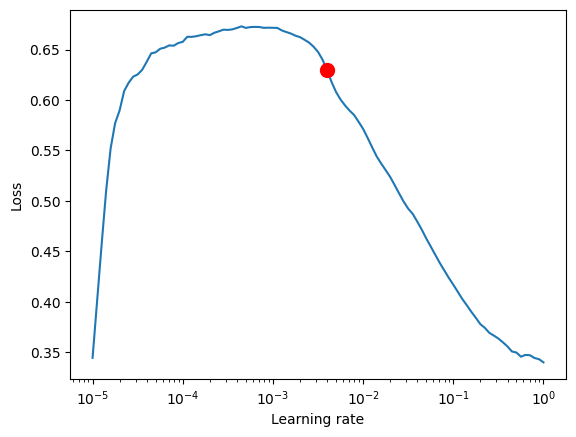

In [27]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [28]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", filename="best_model", mode="min", save_top_k=1)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = GAS_LSTM.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=GAS_MAE(), 
    gas_params= gas_params,
)

net.hparams.learning_rate = res.suggestion()

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | GAS_MAE        | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.6 K
4 | output_projector | Linear         | 31    
5 | AR_GAS           | AR_GAS         | 0     
----------------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


Epoch 6:   7%|▋         | 2/29 [00:03<00:50,  0.54it/s, v_num=10, train_loss_step=0.0902, val_loss=0.142, train_loss_epoch=0.0888] 

In [29]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = GAS_LSTM.load_from_checkpoint(best_model_path)
print(best_model_path)

c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\lightning_logs\version_10\checkpoints\best_model.ckpt


In [30]:
#best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
print(MAE()(predictions.output, predictions.y))

net = best_model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.9496]]), tensor([[-0.9450]]), tensor([[-0.9154]]), tensor([[-0.8889]]), tensor([[-0.8634]]), tensor([[-0.8380]]), tensor([[-0.8122]]), tensor([[-0.7856]]), tensor([[-0.7583]]), tensor([[-0.7301]]), tensor([[-0.7012]]), tensor([[-0.6714]]), tensor([[-0.6408]]), tensor([[-0.6096]]), tensor([[-0.5777]]), tensor([[-0.5453]]), tensor([[-0.5123]]), tensor([[-0.4788]]), tensor([[-0.4450]]), tensor([[-0.4109]]), tensor([[-0.3766]]), tensor([[-0.3422]]), tensor([[-0.3077]]), tensor([[-0.2733]]), tensor([[-0.2389]]), tensor([[-0.2048]]), tensor([[-0.1709]]), tensor([[-0.1373]]), tensor([[-0.1042]]), tensor([[-0.0714]]), tensor([[-0.0392]]), tensor([[-0.0076]]), tensor([[0.0235]]), tensor([[0.0539]]), tensor([[0.0837]]), tensor([[0.1127]]), tensor([[0.1411]]), tensor([[0.1688]]), tensor([[0.1957]]), tensor([[0.2219]]), tensor([[0.2473]]), tensor([[0.2719]]), tensor([[0.2958]]), tensor([[0.3190]]), tensor([[0.3413]]), tensor([[0.3629]]), tensor([[0.3838]]), tensor([[0.4039]]), tensor(

In [31]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.9496]]), tensor([[-0.9450]]), tensor([[-0.9154]]), tensor([[-0.8889]]), tensor([[-0.8634]]), tensor([[-0.8380]]), tensor([[-0.8122]]), tensor([[-0.7856]]), tensor([[-0.7583]]), tensor([[-0.7301]]), tensor([[-0.7012]]), tensor([[-0.6714]]), tensor([[-0.6408]]), tensor([[-0.6096]]), tensor([[-0.5777]]), tensor([[-0.5453]]), tensor([[-0.5123]]), tensor([[-0.4788]]), tensor([[-0.4450]]), tensor([[-0.4109]]), tensor([[-0.3766]]), tensor([[-0.3422]]), tensor([[-0.3077]]), tensor([[-0.2733]]), tensor([[-0.2389]]), tensor([[-0.2048]]), tensor([[-0.1709]]), tensor([[-0.1373]]), tensor([[-0.1042]]), tensor([[-0.0714]]), tensor([[-0.0392]]), tensor([[-0.0076]]), tensor([[0.0235]]), tensor([[0.0539]]), tensor([[0.0837]]), tensor([[0.1127]]), tensor([[0.1411]]), tensor([[0.1688]]), tensor([[0.1957]]), tensor([[0.2219]]), tensor([[0.2473]]), tensor([[0.2719]]), tensor([[0.2958]]), tensor([[0.3190]]), tensor([[0.3413]]), tensor([[0.3629]]), tensor([[0.3838]]), tensor([[0.4039]]), tensor(

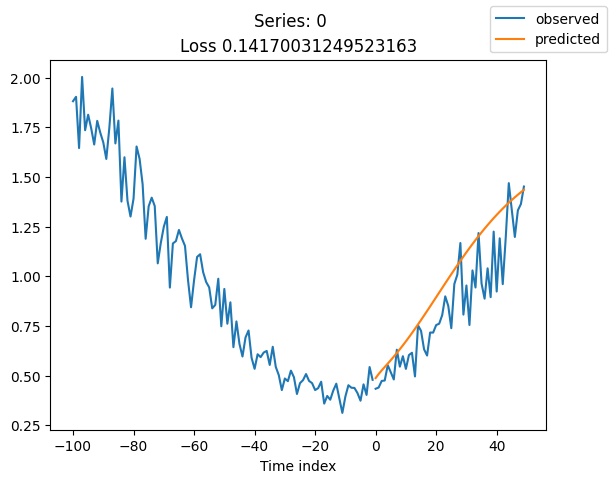

In [32]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")
    

In [54]:
#Test the model on the test set

predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), mode='raw', return_index=True, return_y=True, return_x=True)



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[0.5560]]), tensor([[0.5285]]), tensor([[0.5785]]), tensor([[0.6236]]), tensor([[0.6658]]), tensor([[0.7058]]), tensor([[0.7439]]), tensor([[0.7805]]), tensor([[0.8154]]), tensor([[0.8487]]), tensor([[0.8804]]), tensor([[0.9104]]), tensor([[0.9389]]), tensor([[0.9656]]), tensor([[0.9907]]), tensor([[1.0142]]), tensor([[1.0361]]), tensor([[1.0564]]), tensor([[1.0752]]), tensor([[1.0925]]), tensor([[1.1083]]), tensor([[1.1227]]), tensor([[1.1359]]), tensor([[1.1477]]), tensor([[1.1584]]), tensor([[1.1679]]), tensor([[1.1763]]), tensor([[1.1838]]), tensor([[1.1903]]), tensor([[1.1960]]), tensor([[1.2009]]), tensor([[1.2051]]), tensor([[1.2085]]), tensor([[1.2113]]), tensor([[1.2136]]), tensor([[1.2153]]), tensor([[1.2166]]), tensor([[1.2174]]), tensor([[1.2178]]), tensor([[1.2178]]), tensor([[1.2175]]), tensor([[1.2169]]), tensor([[1.2159]]), tensor([[1.2148]]), tensor([[1.2134]]), tensor([[1.2118]]), tensor([[1.2100]]), tensor([[1.2080]]), tensor([[1.2059]]), tensor([[1.2037]]),

In [93]:
print(MAE()(predictions.output.prediction.squeeze(), predictions.x['decoder_target']))


tensor(0.2676)


0
105
211
316
422
527
633
738
844
950


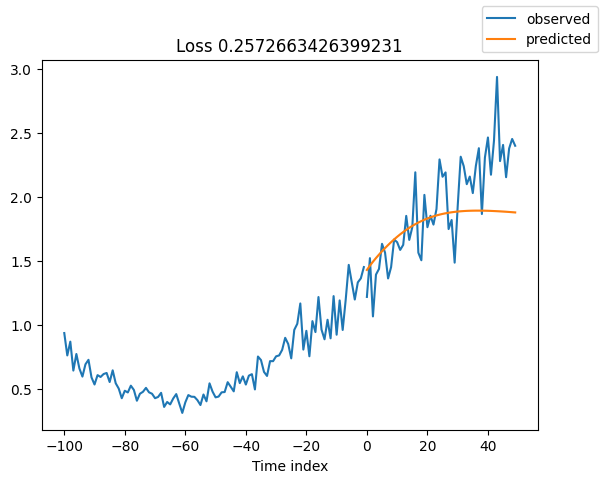

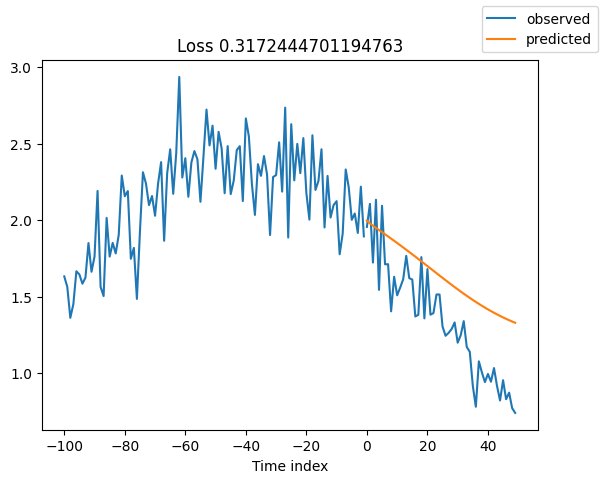

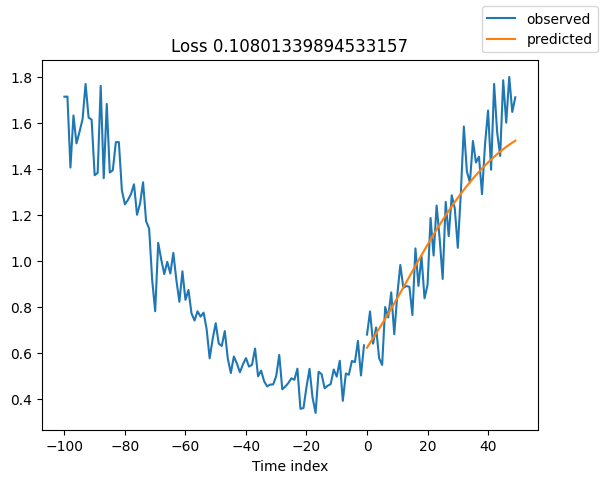

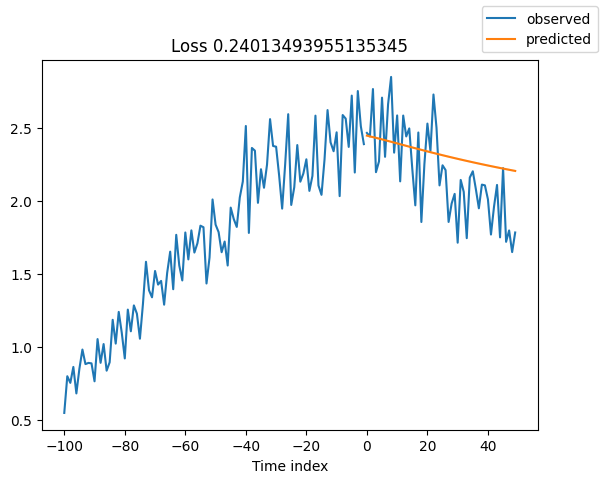

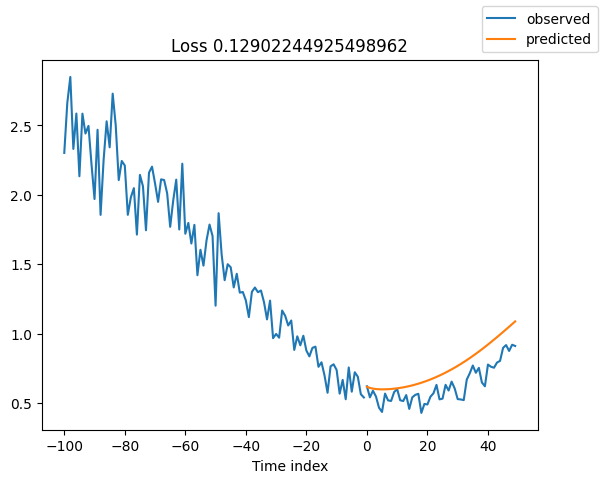

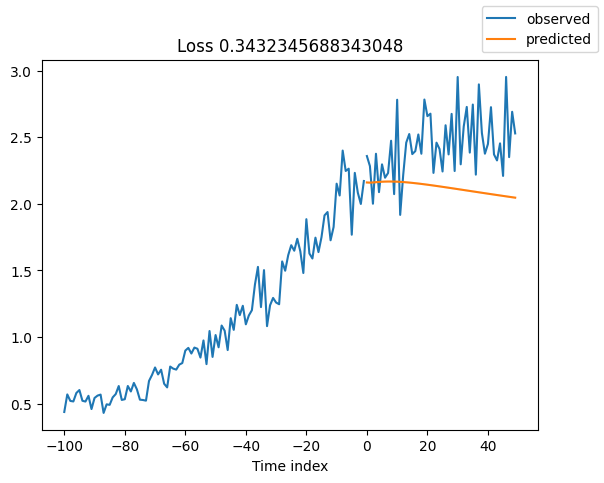

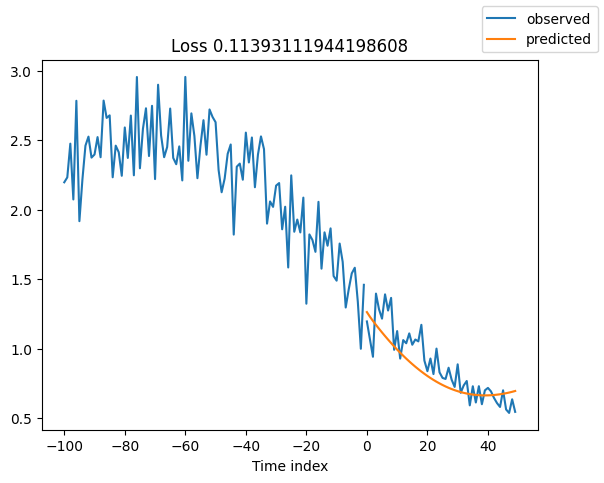

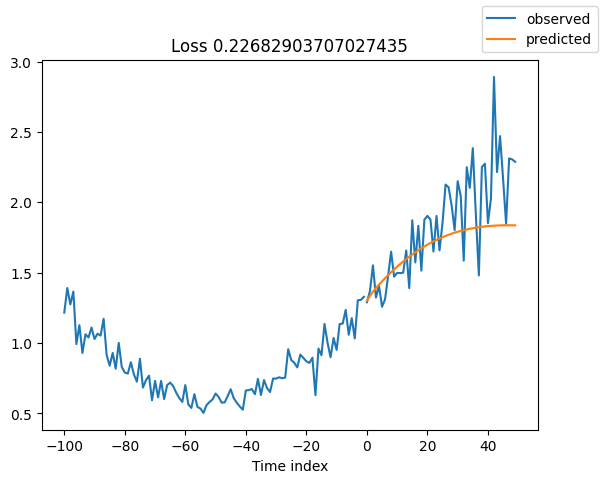

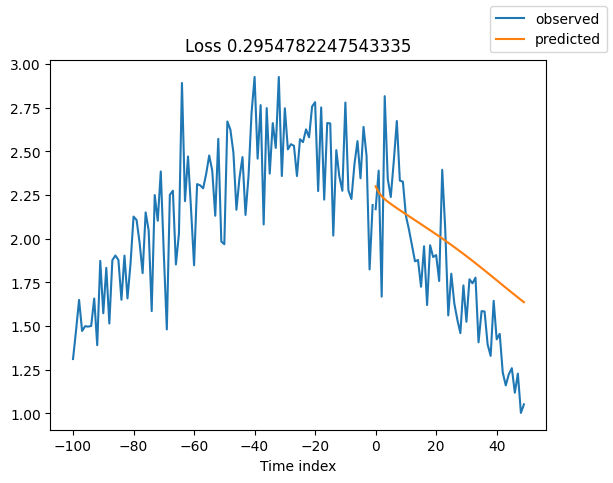

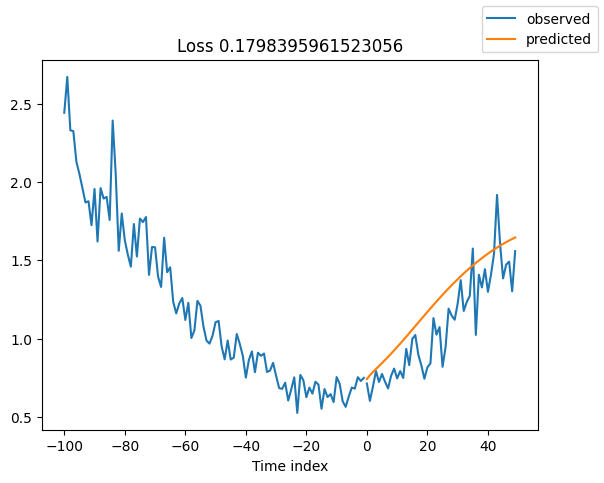

In [105]:

for i in np.linspace(0, predictions.x['encoder_target'].shape[0]-1, 10, dtype=int):
    print(i)
    best_model.plot_prediction(predictions.x, predictions.output, idx=i, add_loss_to_title=True)

951